In [ ]:
# Importing Libraries
import re
import os
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install streamlit pandas matplotlib seaborn scikit-learn
import streamlit as st
!pip install pyngrok
from pyngrok import ngrok
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

books = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Books.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1',)
users = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Users.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1',)
ratings = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Book-Ratings.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1',)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Mounted at /content/drive
Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


# Pre-processing

**Books Dataset Pre-processing**

In [ ]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [ ]:
## Checking for null values
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2


In [ ]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [ ]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [ ]:
books.at[187689 ,'Book-Author'] = 'Other'
books.at[118033 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
pd.set_option('display.max_colwidth', None)
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [ ]:
books.loc[books['Book-Title'] == 'Tyrant Moon',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,Other


In [ ]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [ ]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [ ]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
books.loc[books['Publisher'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
63,2070423204,Lieux dits,Michel Tournier,2002,Gallimard
731,2070417743,Chroniques martiennes,Ray Bradbury,2002,Gallimard
733,2070384349,La Faute de l'abbÃ?Â© Mouret,Emile Zola,1991,Gallimard
1613,2070417700,Deus Irae,Philip Kindred Dick,2001,Gallimard
1614,2070360075,Le Vieil Homme et la Mer,Ernest Hemingway,1972,Gallimard
...,...,...,...,...,...
270315,207036965X,Black Boy,Richard Wright,1974,Gallimard
270316,207037226X,Le Sang noir,Guilloux,1980,Gallimard
270778,2070364569,Ennemonde et autres caractÃ?Â¨res,Jean Giono,1973,Gallimard
270779,2070426297,H4Blues,Jean-Bernard Pouy,2003,Gallimard


In [ ]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [ ]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [ ]:
books.loc[books['Year-Of-Publication'] > 2024, 'Year-Of-Publication'] = 2004
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2004
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True)
books.reset_index(drop = True, inplace = True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
books = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Books.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1')

# Replace all occurrences of '&amd' with NaN
books.replace("&amd", np.nan, inplace=True)



In [ ]:
books.head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg
6,0425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0425176428.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0425176428.01.LZZZZZZZ.jpg
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671870432.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671870432.01.LZZZZZZZ.jpg
8,0679425608,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0679425608.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0679425608.01.LZZZZZZZ.jpg
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/074322678X.01.LZZZZZZZ.jpg


**Users Dataset Pre-processing**

In [ ]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
## Checking null values
print(users.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


In [ ]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [ ]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]
mean = round(required['Age'].mean())
mean

35

In [ ]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age greater than 80 are substituted with mean
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [ ]:
# Check if the 'Location' column exists
if 'Location' in users.columns:
    # Split the 'Location' column into city, state, and country parts
    location_split = users['Location'].str.split(', ', expand=True)

    # Initialize city, state, and country lists
    city = location_split[0].str.lower().fillna('other').replace(['', ' ', 'n/a', ','], 'other')
    state = location_split[1].str.lower().fillna('other').replace(['', ' ', 'n/a', ','], 'other')
    country = location_split[2].str.lower().fillna('other').replace(['', ' ', 'n/a', ','], 'other')

    # Count entries without state or country
    count_no_state = state[state == 'other'].count()
    count_no_country = country[country == 'other'].count()

    # Handle cases where city/state are combined
    city = city.str.split('/').str[0].fillna('other')

    # Drop the original 'Location' column
    users = users.drop('Location', axis=1)

    # Add the new city, state, and country columns to the DataFrame
    users['City'] = city
    users['State'] = state
    users['Country'] = country

    # Output the counts of missing states and countries
    print(f"Number of locations without a valid state: {count_no_state}")
    print(f"Number of locations without a valid country: {count_no_country}")
else:
    print("The 'Location' column does not exist in the users DataFrame.")


Number of locations without a valid state: 16046
Number of locations without a valid country: 4666


In [ ]:
# Check if the 'Location' column exists before trying to access it
if 'Location' in users.columns:
    list_ = users.Location.str.split(', ')
    city = []
    state = []
    country = []
    count_no_state = 0
    count_no_country = 0

    for i in range(0,len(list_)):
      if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
      else:
        city.append(list_[i][0].lower())

        if(len(list_[i])<2):
           state.append('other')
           country.append('other')
           count_no_state += 1
           count_no_country += 1
        else:
          if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries
            state.append('other')
            count_no_state += 1
          else:
            state.append(list_[i][1].lower())
            if(len(list_[i])<3):
              country.append('other')
              count_no_country += 1
            else:
              if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
              else:
                country.append(list_[i][2].lower())
    users = users.drop('Location',axis=1)

    temp = []
    for ent in city:
        c = ent.split('/')            #handling cases where city/state entries from city list as state is already given
        temp.append(c[0])

    df_city = pd.DataFrame(temp,columns=['City'])
    df_state = pd.DataFrame(state,columns=['State'])
    df_country = pd.DataFrame(country,columns=['Country'])

    users = pd.concat([users, df_city], axis=1)
    users = pd.concat([users, df_state], axis=1)
    users = pd.concat([users, df_country], axis=1)

    print(count_no_country)   #printing the number of countries didnt have any values
    print(count_no_state)     #printing the states which didnt have any values

else:
    print("The 'Location' column does not exist in the users DataFrame.")

The 'Location' column does not exist in the users DataFrame.


In [ ]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [ ]:
users.head(6)

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom
5,6,61,santa monica,california,usa


**Books-Ratings Dataset Pre-processing**

In [ ]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
## Checking for null values
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


In [ ]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [ ]:
## checking ISBN
flag = 0
x =[]
reg = "[^A-Za-z0-9]"

for y in ratings['ISBN']:
    z = re.search(reg,y)
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [ ]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_Value in ratings.iterrows():
    a = re.search(reg, row_Value['ISBN'])
    if a:
        b = re.sub(reg,"",row_Value['ISBN'])
        if b in bookISBN:
            ratings.at[index , 'ISBN'] = b

In [ ]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


# Merging of all three Tables

 **Books, Users and Rating Tables in One**

In [ ]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031364 entries, 0 to 1031363
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031364 non-null  object
 1   Book-Title           1031364 non-null  object
 2   Book-Author          1031362 non-null  object
 3   Year-Of-Publication  1031364 non-null  object
 4   Publisher            1031362 non-null  object
 5   Image-URL-S          1031364 non-null  object
 6   Image-URL-M          1031364 non-null  object
 7   Image-URL-L          1031360 non-null  object
 8   User-ID              1031364 non-null  int64 
 9   Book-Rating          1031364 non-null  int64 
 10  Age                  1031364 non-null  int64 
 11  City                 1031364 non-null  object
 12  State                1031364 non-null  object
 13  Country              1031364 non-null  object
dtypes: int64(3), object(11)
memory usage: 110.2+ MB


**Divide complete data on the basis of Implicit and Explicit ratings datasets**

In [ ]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(383981, 14)

In [ ]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647383, 14)

In [ ]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5,35,timmins,ontario,canada
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,11676,8,35,other,other,other
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,67544,8,30,toronto,ontario,canada
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,116866,9,35,ottawa,other,other
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,123629,9,35,kingston,ontario,canada


# Data Visualization

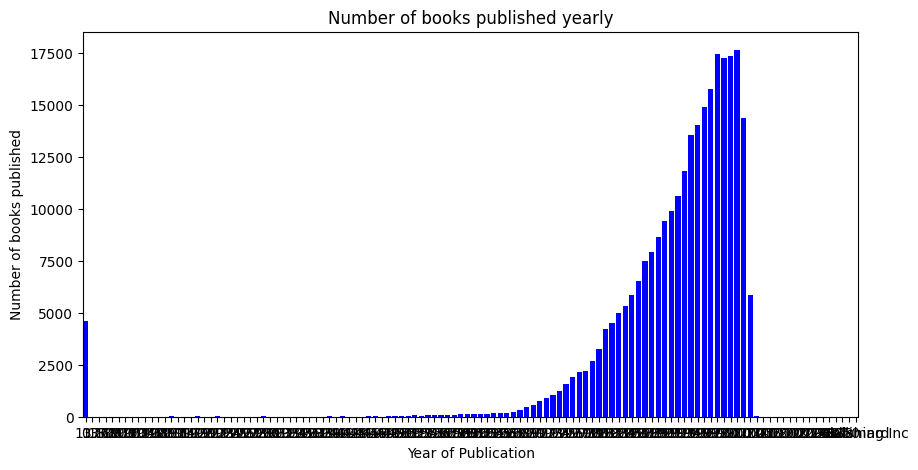

In [ ]:
#Initialize an empty dictionary to store the number of books published per year
publications = {}

#Loop through each year in the 'Year-Of-Publication' column
for year in books['Year-Of-Publication']:
    if str(year) not in publications:    #If the year is not already in the dictionary, add it with a count of 0
        publications[str(year)] = 0
    publications[str(year)] +=1     #Increment the count for the current year

#Sort the dictionary by year
publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(10, 5)) #Create a figure with a specific size for the plot
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')  #Create a bar chart with years on the x-axis and counts on the y-axis
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0) #Remove margins on the x-axis to make the plot fit tightly
plt.show()

Text(0.5, 1.0, 'No. of books by an author (Top 15)')

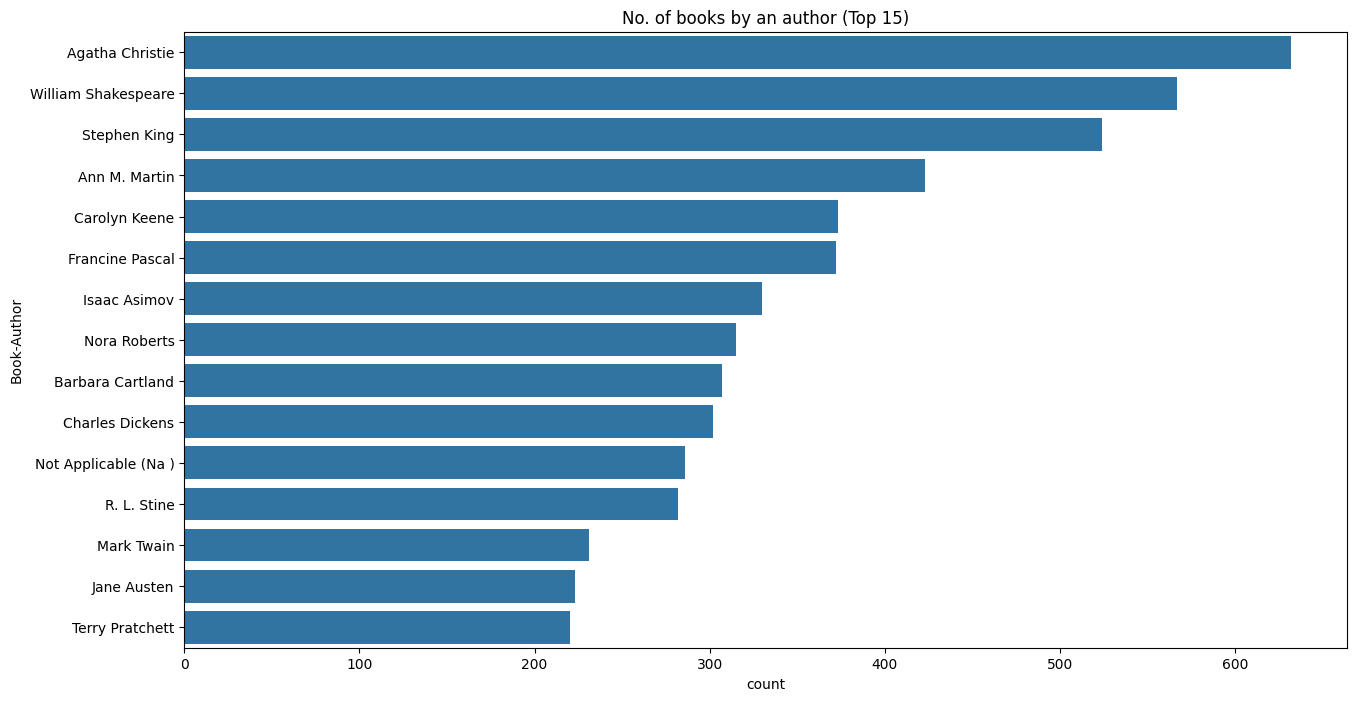

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No. of books by an author (Top 15)")

Text(0.5, 1.0, 'No. of books by an author (Top 15)')

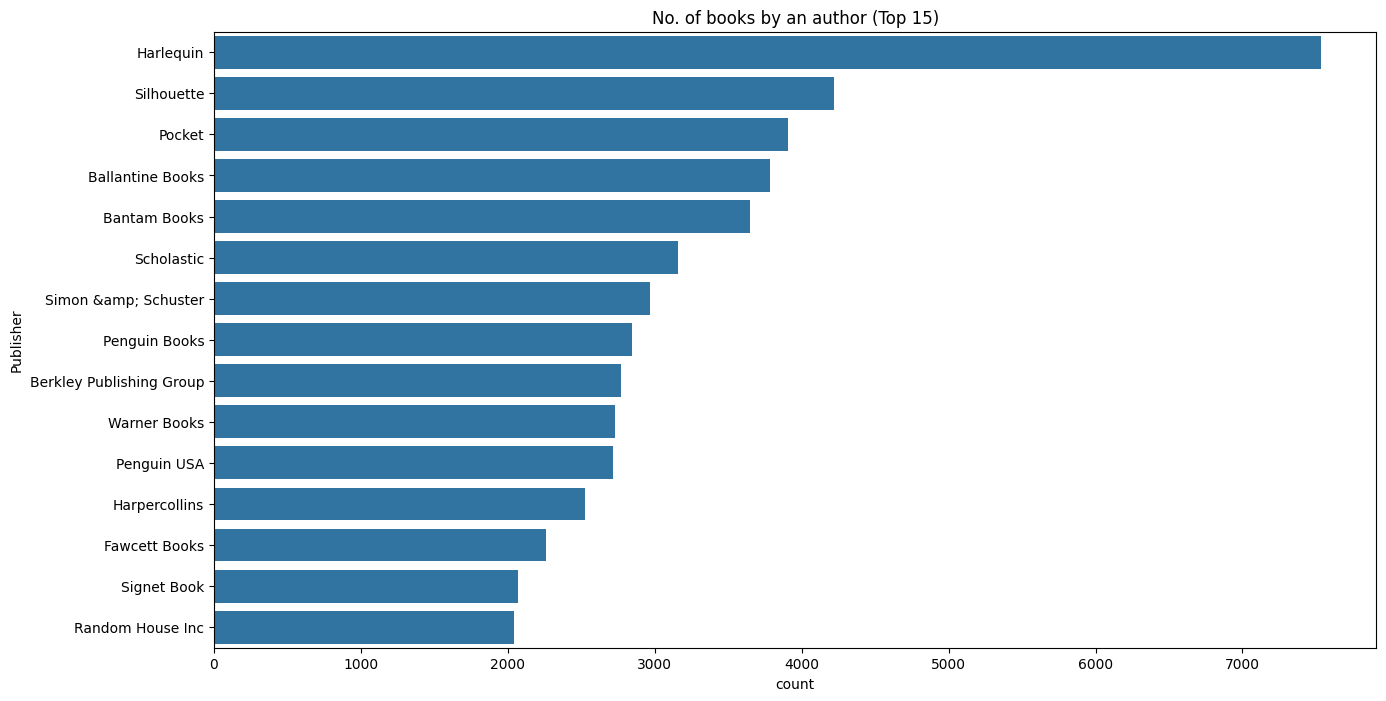

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No. of books by an author (Top 15)")

<Axes: xlabel='Book-Rating', ylabel='count'>

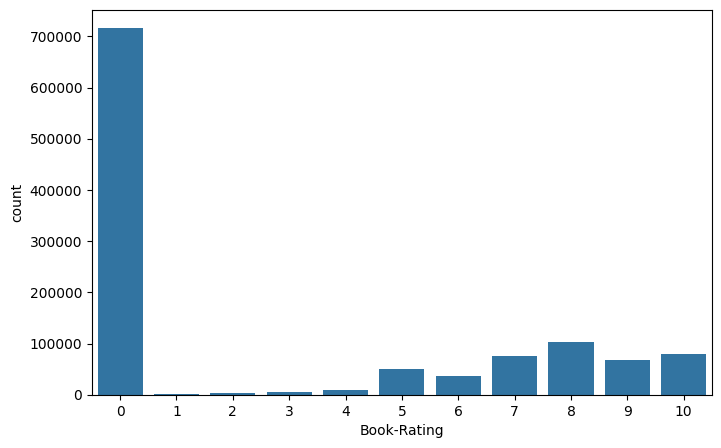

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

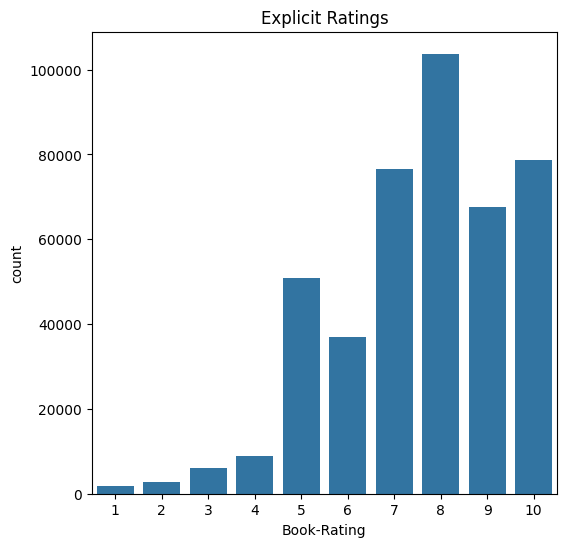

In [ ]:
## Explicit Ratings
plt.figure(figsize=(6,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

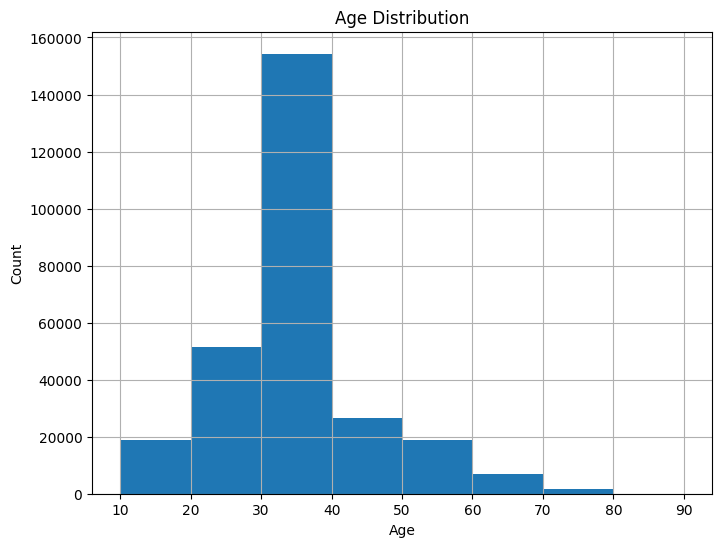

In [ ]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No. of readers from each city (Top 15)')

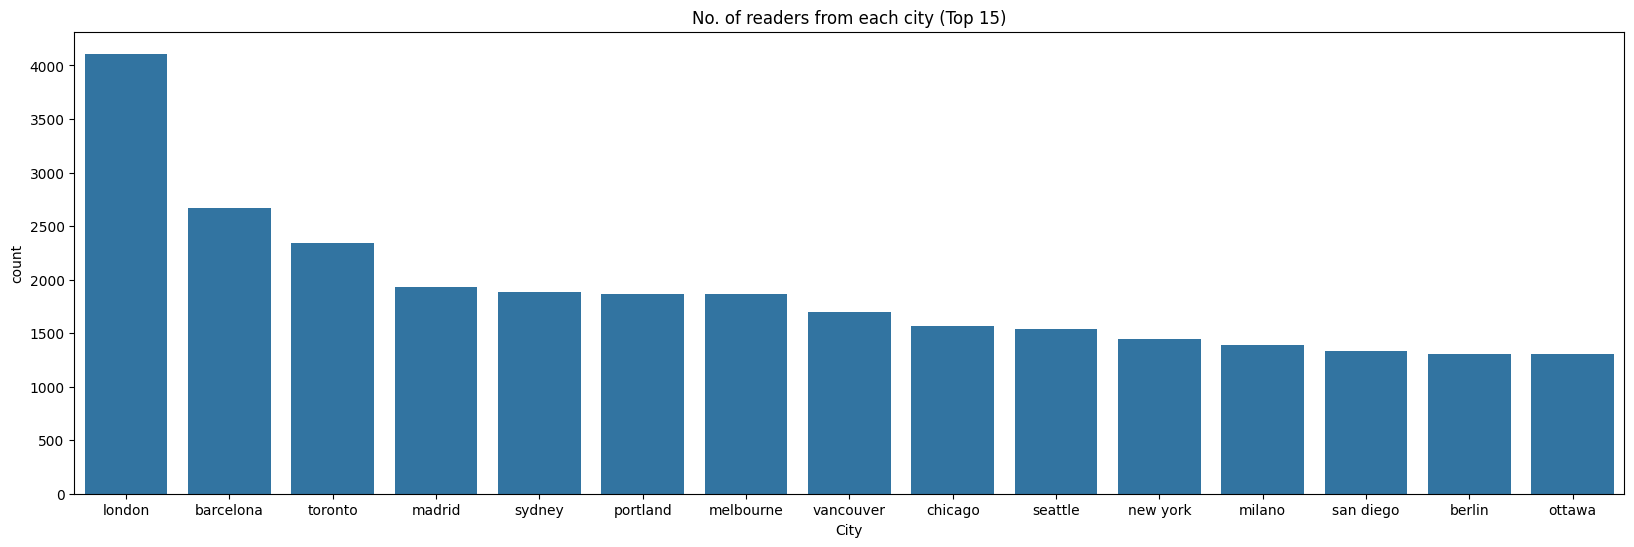

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No. of readers from each city (Top 15)")

Text(0.5, 1.0, 'No. of readers from each state (Top 15)')

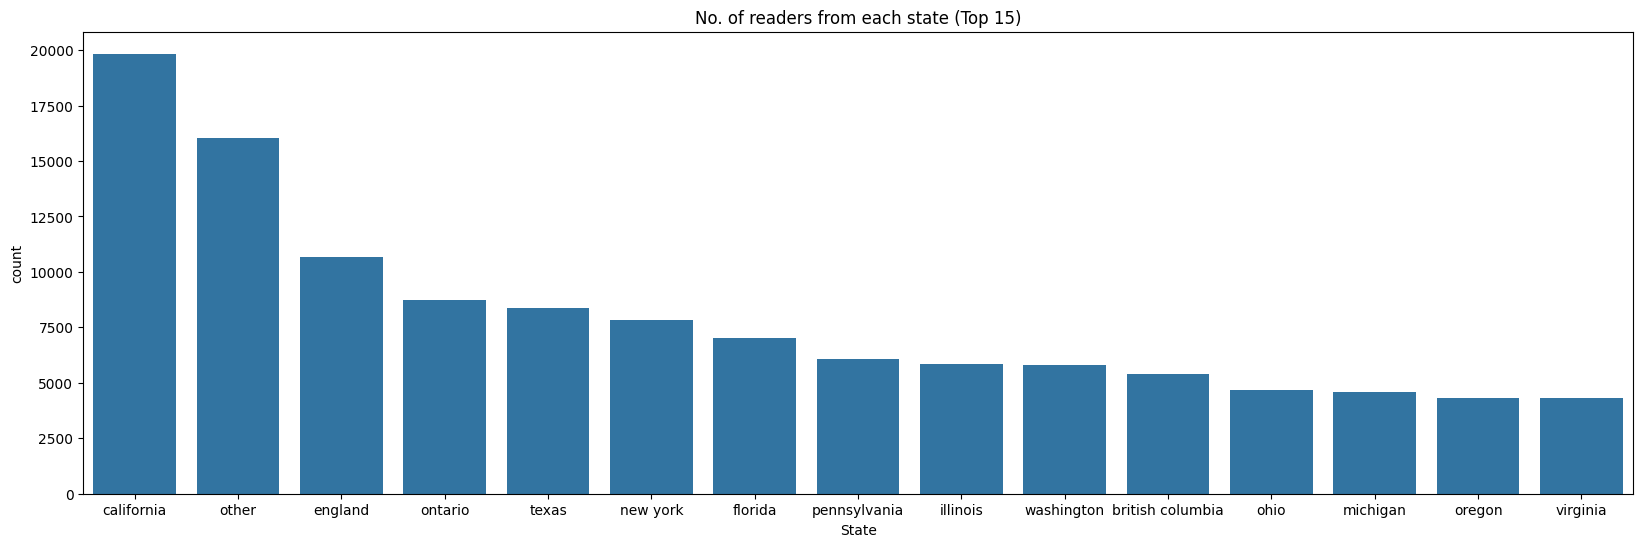

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No. of readers from each state (Top 15)")

Text(0.5, 1.0, 'No. of readers from states of USA (Top 15)')

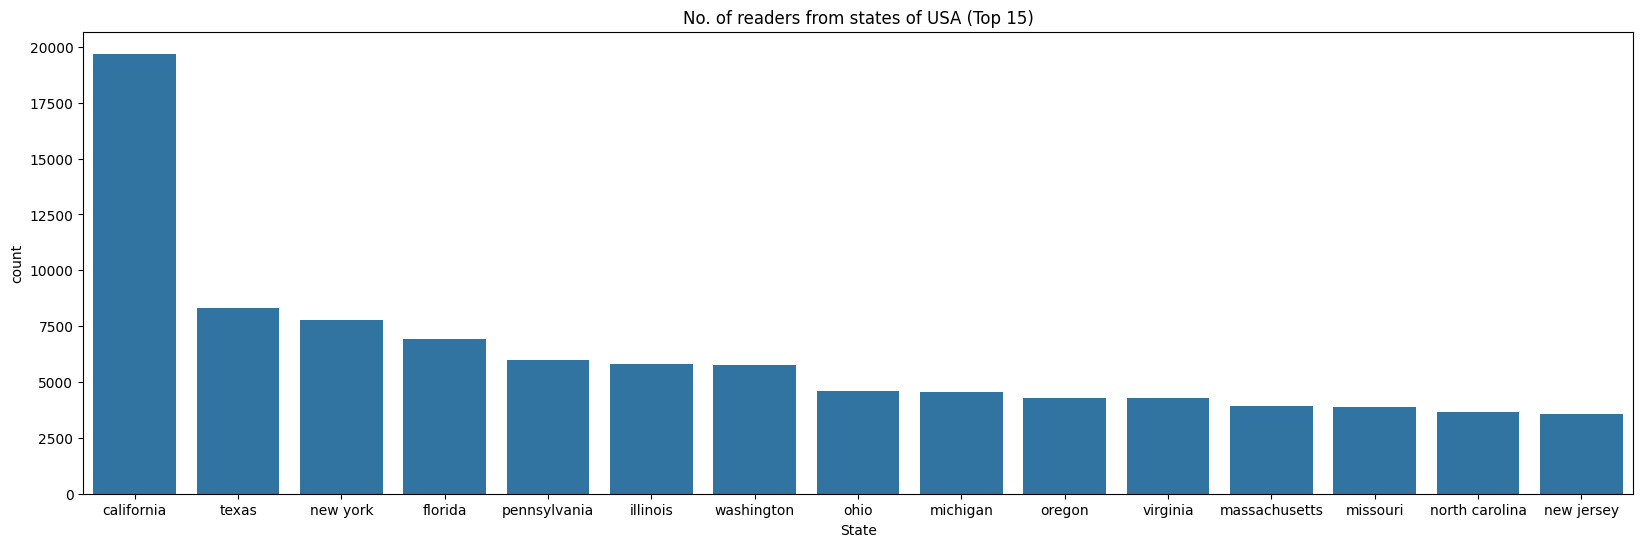

In [ ]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No. of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

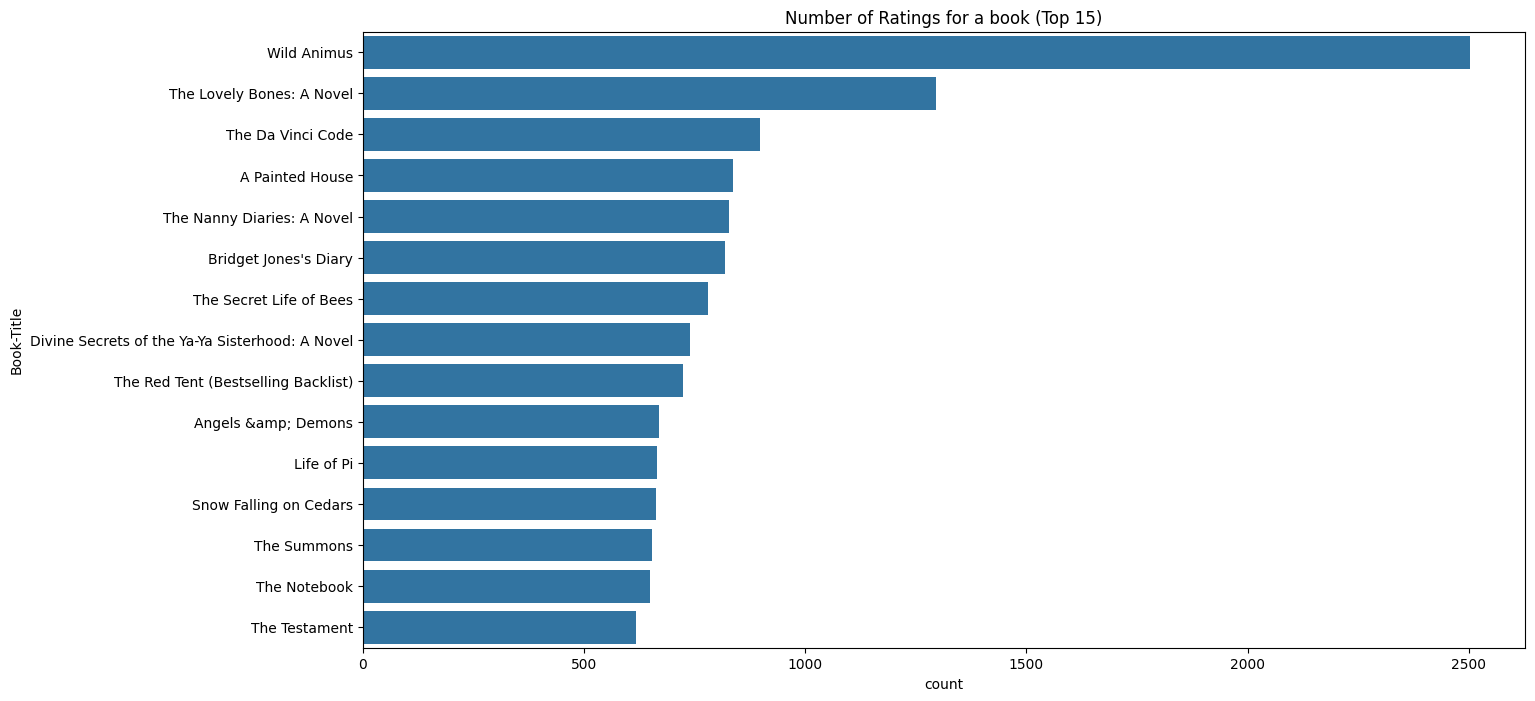

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

# Recommendation Systems

In [ ]:
bookName = input("Enter a book name: ")

while True:
    try:
        num=int(input("Enter number of books to recommend: "))
        break
    except ValueError:
        print("Please enter a valid integer for the number of books.")
#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
#Murder on the Orient Express (Hercule Poirot Mysteries (Paperback))


Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


# 1. Popularity Based (Top In whole collection)

In [ ]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe): #checks n does not exceed total no.of books available in dataframe
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        # Merge the count data with the books DataFrame on the 'ISBN' column
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Invalid number of books entered!!"

In [ ]:
print("Top", num, "Popular books are: ")
popularity_based(dataset1, num)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg


# 3. Books by same author, publisher of given book name

In [ ]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [ ]:

def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        print(au[0])
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

In [ ]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, num)
else:
    print("Invalid Book Name!!")


Books by same Author:

J. K. Rowling
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Prisoner of Azkaban (Book 3)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
The Mouse and His Child


# 4. Books popular Yearly

In [ ]:
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN')

# Convert 'Year-Of-Publication' to numeric, coercing errors to NaN
data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'], errors='coerce')

years = set()
indices = []
for ind, row in data.iterrows():
    year = row['Year-Of-Publication']
    # Check if year is valid (not NaN) before adding to set
    if not pd.isna(year) and year in years:
        indices.append(ind)
    elif not pd.isna(year):
        years.add(year)

data = data.drop(indices)
data = data.drop('Book-Rating', axis=1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
203,0099771519,Memoirs of a Geisha Uk,Arthur Golden,0.0,Trafalgar Square,http://images.amazon.com/images/P/0099771519.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.LZZZZZZZ.jpg
73871,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376.0,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/964442011X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/964442011X.01.LZZZZZZZ.jpg
73872,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378.0,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9643112136.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9643112136.01.LZZZZZZZ.jpg
130273,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806.0,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0781228956.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0781228956.01.LZZZZZZZ.jpg
81498,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900.0,Graphic Arts Center Pub Co,http://images.amazon.com/images/P/1551103982.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1551103982.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1551103982.01.LZZZZZZZ.jpg
125502,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901.0,Fireside,http://images.amazon.com/images/P/0671397214.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671397214.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671397214.01.LZZZZZZZ.jpg
47819,0373226888,Tommy's Mom,Linda O. Johnston,1902.0,Harlequin,http://images.amazon.com/images/P/0373226888.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0373226888.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0373226888.01.LZZZZZZZ.jpg
104305,038528120X,CATCH 22,JOSEPH HELLER,1904.0,Delta,http://images.amazon.com/images/P/038528120X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/038528120X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/038528120X.01.LZZZZZZZ.jpg
103161,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906.0,Ams Pr,http://images.amazon.com/images/P/0404089119.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0404089119.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0404089119.01.LZZZZZZZ.jpg
20957,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908.0,Yoga Publication Society,http://images.amazon.com/images/P/0911662251.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0911662251.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0911662251.01.LZZZZZZZ.jpg


# 5. Average Weighted Ratings

In [ ]:
def avgRating(newdf, df):
    #Calculate the average rating for each book title using a more efficient approach
    avg_ratings = df.groupby('Book-Title')['Book-Rating'].mean()

    #Map the average ratings back to the newdf
    newdf['Average Rating'] = newdf['Book-Title'].map(avg_ratings)
    return newdf

df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df.columns = ['Total-Ratings']
df['Book-Title'] = df.index
df.reset_index(drop=True, inplace=True)


df = avgRating(df, dataset1)
df.to_pickle('weightedData')
df = pd.read_pickle('weightedData')
print(df.head())

   Total-Ratings                  Book-Title  Average Rating
0            707   The Lovely Bones: A Novel        8.185290
1            581                 Wild Animus        4.390706
2            495           The Da Vinci Code        8.430303
3            413     The Secret Life of Bees        8.479419
4            393  The Nanny Diaries: A Novel        7.437659


In [ ]:
## C - Mean vote across the whole
C = df['Average Rating'].mean()

## Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:

df = df.loc[df['Total-Ratings'] >= m]

df['score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('score', ascending=False)

print("Recommended Books:-\n")
df.head(num)

Recommended Books:-



,Total-Ratings,Book-Title,Average Rating,score
1935,23,Harry Potter and the Chamber of Secrets Postcard Book,9.869565,9.450518
114,136,"The Two Towers (The Lord of the Rings, Part 2)",9.330882,9.266769
3857,13,Dilbert: A Book of Postcards,9.923077,9.256361
1724,24,Calvin and Hobbes,9.583333,9.228086
4794,11,Postmarked Yesteryear: 30 Rare Holiday Postcards,10.000000,9.225906


# 6. Collaborative Filtering (User-Item Filtering)

In [ ]:
print(dataset1.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating',
       'Age', 'City', 'State', 'Country'],
      dtype='object')


In [ ]:
df.head()

,Total-Ratings,Book-Title,Average Rating,score
1935,23,Harry Potter and the Chamber of Secrets Postcard Book,9.869565,9.450518
114,136,"The Two Towers (The Lord of the Rings, Part 2)",9.330882,9.266769
3857,13,Dilbert: A Book of Postcards,9.923077,9.256361
1724,24,Calvin and Hobbes,9.583333,9.228086
4794,11,Postmarked Yesteryear: 30 Rare Holiday Postcards,10.000000,9.225906


In [ ]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df.iloc[:,0] # Access the counts using the column name
df['Book-Title'] = df.index
df = df.rename_axis('old_index').reset_index() # Rename the existing index before resetting
df = df.rename(columns={'old_index': 'index'}) # Rename the old index column
df = df.drop('index',axis=1) # Drop the old index column

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
df.head()

,ISBN,Book-Title,Book-Author,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,count,Total-Ratings
0,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,8,5,9,9
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,11676,8,9,9
2,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,67544,8,9,9
3,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,116866,9,9,9
4,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,123629,9,9,9


## 7. Correlation Based


In [ ]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [ ]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(num+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books



 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.LZZZZZZZ.jpg
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439136369.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439136369.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439136369.01.LZZZZZZZ.jpg
2,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439139597.01.LZZZZZZZ.jpg
3,0804115613,Fried Green Tomatoes at the Whistle Stop Cafe,Fannie Flagg,2000,Ballantine Books,http://images.amazon.com/images/P/0804115613.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804115613.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804115613.01.LZZZZZZZ.jpg
4,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks,http://images.amazon.com/images/P/0439139600.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439139600.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439139600.01.LZZZZZZZ.jpg


# 8. Nearest Neighbours

In [ ]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])
result = pd.merge(data, dataset1, on='Book-Title', how='left')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = num+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


In [ ]:
'''print(dataset1.columns)
print(data.columns)
print(result.columns)'''

#matrix.index[3]
#matrix.index

''''books_name=matrix.index
print(books_name)

indices'''
for i in range(len(indices)):
  print(matrix.index[indices[i]])

Index(['Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))',
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'The Fellowship of the Ring (The Lord of the Rings, Part 1)'],
      dtype='object', name='Book-Title')


In [ ]:
def recommend_book(book_name):
    ISBN = np.where(matrix.index == book_name)[0][0]
    distances, indices = model.kneighbors(matrix.iloc[ISBN, :].values.reshape(1, -1), n_neighbors = num+1)
    for i in range(len(indices)):
        books = matrix.index[indices[i]]
        for j in books:
          print (j)

book_name = input("Enter a book name: ")
recommend_book(book_name)

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)



# 9. Content Based

In [ ]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 10)

In [ ]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [ ]:
!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer # Make sure to import the necessary module

tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title']) # This line defines the tfidf_matrix variable
tfidf_matrix.shape

(44652, 1112)

In [ ]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < num:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


In [ ]:
def recommend_book(book_name):
    ISBN = np.where(matrix.index == book_name)[0][0]
    distances, indices = model.kneighbors(matrix.iloc[ISBN, :].values.reshape(1, -1), n_neighbors = num+1)

    for i in range(len(indices)):
        books = matrix.index[indices[i]]
        for j in books:
          print (j)

book_name = input("Enter a book name: ")
recommend_book(book_name)

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


In [ ]:
def demographic_recommend(user_id, num_recs):
    user = users[users['User-ID'] == user_id].iloc[0]
    similar_users = users[(users['Age'] == user['Age']) & (users['Country'] == user['Country'])]
    similar_user_ids = similar_users['User-ID'].tolist()
    similar_ratings = dataset1[dataset1['User-ID'].isin(similar_user_ids)]
    top_books = similar_ratings.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False).head(num_recs)
    return books[books['ISBN'].isin(top_books.index)]


In [ ]:
'''from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

# Create the user-item matrix, using a sparse matrix format
user_features = dataset1.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
user_features_sparse = csr_matrix(user_features.values)

# Scale the data to improve performance
scaler = StandardScaler(with_mean=False)  # `with_mean=False` for sparse matrices
user_features_scaled = scaler.fit_transform(user_features_sparse)

# Use MiniBatchKMeans for large datasets
kmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=1000)
user_clusters = kmeans.fit_predict(user_features_scaled)

# Assign clusters to the users
users['Cluster'] = user_clusters

# Define the recommendation function
def cluster_based_recommend(user_id, num_recs):
    cluster = users[users['User-ID'] == user_id]['Cluster'].values[0]
    cluster_users = users[users['Cluster'] == cluster]['User-ID']
    cluster_ratings = dataset1[dataset1['User-ID'].isin(cluster_users)]

    # Get the top rated books in the cluster
    top_books = cluster_ratings.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False).head(num_recs)
    return books[books['ISBN'].isin(top_books.index)]

'''

"from sklearn.cluster import MiniBatchKMeans\nfrom sklearn.preprocessing import StandardScaler\nfrom scipy.sparse import csr_matrix\n\n# Create the user-item matrix, using a sparse matrix format\nuser_features = dataset1.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)\nuser_features_sparse = csr_matrix(user_features.values)\n\n# Scale the data to improve performance\nscaler = StandardScaler(with_mean=False)  # `with_mean=False` for sparse matrices\nuser_features_scaled = scaler.fit_transform(user_features_sparse)\n\n# Use MiniBatchKMeans for large datasets\nkmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=1000)\nuser_clusters = kmeans.fit_predict(user_features_scaled)\n\n# Assign clusters to the users\nusers['Cluster'] = user_clusters\n\n# Define the recommendation function\ndef cluster_based_recommend(user_id, num_recs):\n    cluster = users[users['User-ID'] == user_id]['Cluster'].values[0]\n    cluster_users = users[users['Cluster'] == 

##  Personalized Dashboards and Analytics for Users

In [ ]:
# Create the directory if it doesn't exist
if not os.path.exists('/content/drive/MyDrive/book recommendation systema/rtifacts'):
    os.makedirs('/content/drive/MyDrive/book recommendation system/artifacts', exist_ok=True) # Set exist_ok to True to avoid FileExistsError

pickle.dump(model, open('/content/drive/MyDrive/book recommendation system/artifacts/model.pk', 'wb'))
pickle.dump(book_name, open('/content/drive/MyDrive/book recommendation system/artifacts/book_name.pk', 'wb'))
pickle.dump(result, open('/content/drive/MyDrive/book recommendation system/artifacts/result.pk', 'wb'))
pickle.dump(matrix, open('/content/drive/MyDrive/book recommendation system/artifacts/matrix.pk', 'wb'))

In [ ]:
!pip install streamlit pyngrok

# Import ngrok and streamlit
from pyngrok import ngrok

ngrok.set_auth_token("2mmi83jQifc0hGObv5uLBxCidEh_2MurhCNCkbaBxB9DbD7qR")

# Kill any existing ngrok processes
!killall ngrok # This line is added to terminate existing tunnels

# Connect and start the tunnel on port 8501
tunnel = ngrok.connect(addr=8501)
public_url = tunnel.public_url # Get the public URL of the tunnel

print(f"Streamlit app will be accessible on: {public_url}")

code = '''
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import operator
import re

# Function to load data
@st.cache_data
def load_data():
    books = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Books.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1')
    users = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Users.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1')
    ratings = pd.read_csv("/content/drive/MyDrive/book recommendation system/books/books_data/Book-Ratings.csv", delimiter=';', on_bad_lines='skip', encoding='ISO-8859-1')
    return books, users, ratings

books, users, ratings = load_data()

# Data Preprocessing
def preprocess_data():
    # Drop unwanted columns and handle missing values in 'books' data
    books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
    books.fillna({'Book-Author': 'Other', 'Publisher': 'Other', 'Year-Of-Publication': 2000}, inplace=True)
    books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce').fillna(2000).astype(int)

    # Process 'users' data: Handle missing ages, split location
    users['Age'] = users['Age'].fillna(users['Age'].mean()).astype(int)
    location_split = users['Location'].str.split(', ', expand=True)
    users['City'] = location_split[0].fillna('other').str.lower()
    users['State'] = location_split[1].fillna('other').str.lower()
    users['Country'] = location_split[2].fillna('other').str.lower()

    # Process ratings data and ensure ISBN consistency
    ratings.dropna(subset=['Book-Rating'], inplace=True)
    ratings['ISBN'] = ratings['ISBN'].str.upper()

    # Merging datasets
    dataset = pd.merge(books, ratings, on='ISBN', how='inner')
    dataset = pd.merge(dataset, users, on='User-ID', how='inner')
    return dataset

dataset = preprocess_data()

# Function to calculate popular books
def popularity_based(dataframe, n):
    data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
    result = pd.merge(data, books, on='ISBN')
    return result

# Function to get books by the same author/publisher
def get_books_by_author_publisher(dataframe, book_name, n):
    book_info = dataframe[dataframe['Book-Title'] == book_name].iloc[0]
    author_books = dataframe[(dataframe['Book-Author'] == book_info['Book-Author']) & (dataframe['Book-Title'] != book_name)].head(n)
    publisher_books = dataframe[(dataframe['Publisher'] == book_info['Publisher']) & (dataframe['Book-Title'] != book_name)].head(n)
    return author_books, publisher_books

# Function to generate yearly popular books
def get_yearly_popular_books(dataframe):
    data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
    data = pd.merge(data, books, on='ISBN')
    data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'], errors='coerce')
    data = data.drop_duplicates('Year-Of-Publication').sort_values('Year-Of-Publication')
    return data

def content_based_recommender(book_id, num_recommendations=5):
    """Recommend books based on content similarity."""
    try:
        book_features = books.pivot(index='book_id', columns='tag_id', values='tag_value').fillna(0)
        cosine_sim = cosine_similarity(book_features)
        idx = book_features.index.get_loc(book_id)
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:num_recommendations+1]
        book_indices = [i[0] for i in sim_scores]
        return books.iloc[book_indices]
    except Exception as e:
        st.write(f"Error in Content-Based Filtering: {e}")

def collaborative_filtering_recommender(user_id, num_recommendations=5):
    """Recommend books based on user-item collaborative filtering."""
    try:
        user_item_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
        cosine_sim = cosine_similarity(user_item_matrix)
        user_idx = user_item_matrix.index.get_loc(user_id)
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:num_recommendations+1]
        user_indices = [i[0] for i in sim_scores]
        recommended_books = ratings[ratings['user_id'].isin(user_indices)]
        return recommended_books
    except Exception as e:
        st.write(f"Error in Collaborative Filtering: {e}")

def nearest_neighbors_recommender(book_id, num_recommendations=5):
    """Recommend books using KNN on item-based features."""
    try:
        book_features = books.pivot(index='book_id', columns='tag_id', values='tag_value').fillna(0)
        model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
        model_knn.fit(book_features.values)
        distances, indices = model_knn.kneighbors(book_features.loc[[book_id]].values, n_neighbors=num_recommendations+1)
        recommended_indices = indices.flatten()[1:]
        return books.iloc[recommended_indices]
    except Exception as e:
        st.write(f"Error in Nearest Neighbors: {e}")

# Streamlit Interface
st.title("📚 Book Recommendation System")

st.sidebar.header("Choose Recommendation Approach")
approach = st.sidebar.selectbox(
    "Select Recommendation Method",
    ["Popularity Based", "By Author/Publisher", "Yearly Popular Books", "Collaborative Filtering", "Nearest Neighbors"]
)
book_name = st.text_input("Enter a Book Title", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))")
num_recommendations = st.slider("Number of Books to Recommend", 1, 10, 5)

# Recommendation output based on user choice
st.header("Recommended Books")

if approach == "Popularity Based":
    recommendations = popularity_based(dataset, num_recommendations)
    st.write(recommendations[['Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']])

elif approach == "By Author/Publisher":
    author_books, publisher_books = get_books_by_author_publisher(dataset, book_name, num_recommendations)
    st.write("Books by the Same Author:")
    st.write(author_books[['Book-Title', 'Publisher', 'Year-Of-Publication']])
    st.write("Books by the Same Publisher:")
    st.write(publisher_books[['Book-Title', 'Book-Author', 'Year-Of-Publication']])

elif approach == "Yearly Popular Books":
    yearly_books = get_yearly_popular_books(dataset)
    st.write(yearly_books[['Book-Title', 'Book-Author', 'Year-Of-Publication']])

elif approach == "Content-Based":
    book_id = st.number_input("Enter Book ID for Recommendation:", min_value=1)
    recommendations = content_based_recommender(book_id)
    if recommendations is not None:
        st.write(recommendations[['title', 'authors']])

elif approach == "Collaborative Filtering":
    user_id = st.number_input("Enter User ID for Recommendation:", min_value=1)
    recommendations = collaborative_filtering_recommender(user_id)
    if recommendations is not None:
        st.write(recommendations[['title', 'rating']])

elif approach == "Nearest Neighbors":
  book_id = st.number_input("Enter Book ID for Recommendation:", min_value=1)
  recommendations = nearest_neighbors_recommender(book_id)
  if recommendations is not None:
    st.write(recommendations[['title', 'authors']])

# Display graphs for data analysis
st.sidebar.subheader("Exploratory Data Analysis")
if st.sidebar.checkbox("Ratings Distribution"):
    st.subheader("Ratings Distribution")
    plt.figure(figsize=(10, 5))
    sns.histplot(x='Book-Rating', data=ratings)
    plt.xlabel("Book Rating")
    plt.ylabel("Count")
    st.pyplot(plt)

if st.sidebar.checkbox("Top Rated Books"):
    st.sidebar("Top 10 Most Rated Books")
    top_rated_books = ratings['book_id'].value_counts().head(10)
    top_rated_books_df = pd.DataFrame({'Book ID': top_rated_books.index, 'Ratings Count': top_rated_books.values})
    top_books_merged = top_rated_books_df.merge(books, left_on='Book ID', right_on='book_id')
    st.write(top_books_merged[['title', 'Ratings Count']])

if st.sidebar.checkbox("Ratings Per User Distribution"):
    st.subheader("Ratings Per User Distribution")
    user_rating_counts = ratings.groupby('user_id').size()
    plt.figure(figsize=(10, 4))
    sns.histplot(user_rating_counts, bins=30, kde=True)
    st.pyplot(plt)

if st.sidebar.checkbox("Books Published Per Year"):
    st.subheader("Number of Books Published Per Year")
    publications = books['Year-Of-Publication'].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(publications.index, publications.values, palette="viridis")
    plt.xlabel("Year of Publication")
    plt.ylabel("Number of Books")
    st.pyplot(plt)

if st.sidebar.checkbox("Top Authors by Number of Books"):
    st.subheader("Top Authors by Number of Books")
    top_authors = books['Book-Author'].value_counts().head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_authors.index, x=top_authors.values, palette="viridis")
    plt.xlabel("Number of Books")
    st.pyplot(plt)

st.write("Thank you for using the Book Recommendation System!")
'''
with open('app.py', 'w') as f:
    f.write(code)

print("app.py created!")

# Write the Streamlit app to a Python file
with open('app.py', 'w') as f:
    f.write(code)

# Run the Streamlit app in the background
!streamlit run app.py &>/dev/null&


ERROR:pyngrok.process.ngrok:t=2024-11-07T01:13:00+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2024-11-07T01:13:00+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [ ]:
!pip install streamlit pyngrok

# Import ngrok and streamlit
from pyngrok import ngrok

ngrok.set_auth_token("2mmi83jQifc0hGObv5uLBxCidEh_2MurhCNCkbaBxB9DbD7qR")

# Kill any existing ngrok processes
!killall ngrok # This line is added to terminate existing tunnels

# Connect and start the tunnel on port 8501
tunnel = ngrok.connect(addr=8501)
public_url = tunnel.public_url # Get the public URL of the tunnel

print(f"Streamlit app will be accessible on: {public_url}")

code = '''
# app.py
import pickle
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import os
import requests

# Caching the data loading function to improve performance
@st.cache_data
st.cache_data.clear()
st.experimental_rerun()
def load_data():
    books = pd.read_csv(
        "/content/drive/MyDrive/book recommendation system/books/books_data/Books.csv",
        delimiter=';',
        on_bad_lines='skip',
        encoding='ISO-8859-1',
        low_memory=False,
        quotechar='"'
    )
    users = pd.read_csv(
        "/content/drive/MyDrive/book recommendation system/books/books_data/Users.csv",
        delimiter=';',
        on_bad_lines='skip',
        encoding='ISO-8859-1',
        low_memory=False
    )
    ratings = pd.read_csv(
        "/content/drive/MyDrive/book recommendation system/books/books_data/Book-Ratings.csv",
        delimiter=';',
        on_bad_lines='skip',
        encoding='ISO-8859-1',
        low_memory=False
    )
    return books, users, ratings

# Load data
books, users, ratings = load_data()

# Data Merging
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')

# Define dataset1 (Explicit Ratings Dataset)
dataset1 = dataset[dataset['Book-Rating'] != 0].reset_index(drop=True)

# Define personalized_recommendations function
def personalized_recommendations(user_id, num_recs):
    # Collaborative Filtering (e.g., using matrix factorization or other methods)
    # Placeholder implementation: Recommend top-rated books by the user
    user_ratings = dataset1[dataset1['User-ID'] == user_id]
    favorite_books = user_ratings.sort_values('Book-Rating', ascending=False).head(num_recs)
    return favorite_books[['Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']]

# Function for popularity-based recommendations
def popularity_based(df, n):
    if n >= 1 and n <= len(df):
        data = pd.DataFrame(df.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN')
        return result[['ISBN','Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']]
    return "Invalid number of books entered!"

# Function for recommending books by the same author/publisher
def get_books_by_author_publisher(book_name, n):
    data = dataset[dataset['Book-Title'] == book_name]
    if data.empty:
        return pd.DataFrame(), pd.DataFrame()
    au = data['Book-Author'].unique()
    pub = data['Publisher'].unique()

    same_author = dataset[
        (dataset['Book-Author'].isin(au)) &
        (dataset['Book-Title'] != book_name)
    ].drop_duplicates().head(n)

    same_publisher = dataset[
        (dataset['Publisher'].isin(pub)) &
        (dataset['Book-Title'] != book_name)
    ].drop_duplicates().head(n)

    return same_author[['Book-Title', 'Book-Author', 'Publisher']], same_publisher[['Book-Title', 'Publisher']]

# Function to fetch book details from Google Books API
def get_book_details(isbn):
    try:
        url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
        response = requests.get(url).json()
        if 'items' in response:
            volume_info = response['items'][0]['volumeInfo']
            title = volume_info.get('title', 'N/A')
            authors = ", ".join(volume_info.get('authors', ['N/A']))
            description = volume_info.get('description', 'No description available.')
            image = volume_info.get('imageLinks', {}).get('thumbnail', '')
            return title, authors, description, image
        return 'N/A', 'N/A', 'No description available.', ''
    except Exception as e:
        return 'N/A', 'N/A', 'No description available.',

# Function to display recommendations with details
def display_recommendations(recommendations):
    if recommendations.empty:
        st.write("No recommendations to display.")
        return
    for _, row in recommendations.iterrows():
        title, authors, description, image = get_book_details(row['ISBN'])
        cols = st.columns([1, 3])
        with cols[0]:
            if image != '':
                st.image(image, width=100, caption=title)
            else:
                st.write("No Image Available")
        with cols[1]:
            st.markdown(f"### {title}")
            st.markdown(f"**Author:** {authors}")
            st.markdown(f"**Publisher:** {row['Publisher']}")
            st.markdown(f"**Year:** {row['Year-Of-Publication']}")
            st.markdown(f"**Description:** {description[:200]}...")  # Truncate description for brevity
            st.markdown("---")

# Streamlit App UI
st.title("📚 **Book Recommendation System** 📚")

# Sidebar for Recommendation Type and User Selection
st.sidebar.header("🔍 **Options**")
rec_type = st.sidebar.selectbox("Choose Recommendation Type", ("Popularity Based", "Books by Same Author/Publisher", "Personalized Recommendations"))

if rec_type == "Personalized Recommendations":
    user_id = st.sidebar.selectbox("Select User ID", users['User-ID'].unique())
    st.subheader("📊 **Your Reading Statistics**")
    user_data = dataset1[dataset1['User-ID'] == user_id]
    total_books_read = user_data['ISBN'].nunique()
    favorite_genre = user_data['Genre'].str.split('|').explode().mode()
    favorite_genre = favorite_genre[0] if not favorite_genre.empty else "N/A"
    st.write(f"**Total Books Read:** {total_books_read}")
    st.write(f"**Favorite Genre:** {favorite_genre}")

    st.subheader("⭐ **Personalized Recommendations**")
    num_books = st.number_input("Number of books to recommend", min_value=1, max_value=50, step=1, value=5)
    with st.spinner('Generating recommendations...'):
        recs = personalized_recommendations(user_id, num_books)
    if isinstance(recs, str):
        st.error(recs)
    else:
        display_recommendations(recs)

elif rec_type == "Popularity Based":
    st.subheader("🌟 **Top Popular Books**")
    num_books = st.number_input("Number of books to recommend", min_value=1, max_value=50, step=1, value=5)
    with st.spinner('Fetching popular books...'):
        result = popularity_based(dataset1, num_books)
    if isinstance(result, str):
        st.error(result)
    else:
        display_recommendations(result)

elif rec_type == "Books by Same Author/Publisher":
    st.subheader("🔗 **Find Books by Same Author or Publisher**")
    book_name = st.text_input("Enter a book name (e.g., Harry Potter)")
    if book_name:
        if book_name in dataset['Book-Title'].unique():
            num_books = st.number_input("Number of books to recommend", min_value=1, max_value=50, step=1, value=5, key='publisher_recs')
            with st.spinner('Fetching recommendations...'):
                same_author, same_publisher = get_books_by_author_publisher(book_name, num_books)
            if not same_author.empty:
                st.markdown("**📚 Books by the Same Author:**")
                display_recommendations(same_author)
            else:
                st.write("No other books found by the same author.")
            if not same_publisher.empty:
                st.markdown("**🏢 Books by the Same Publisher:**")
                display_recommendations(same_publisher)
            else:
                st.write("No other books found by the same publisher.")
        else:
            st.error("🔴 **Book not found!** Please check the spelling or try a different book.")


# Footer
st.markdown("---")
st.write("© 2024 **Book Recommendation System**. All rights reserved.")
'''

with open('app.py', 'w') as f:
    f.write(code)

print("app.py created!")

# Write the Streamlit app to a Python file
with open('app.py', 'w') as f:
    f.write(code)

# Run the Streamlit app in the background
!streamlit run app.py &>/dev/null&

Streamlit app will be accessible on: https://1ef8-34-125-129-144.ngrok-free.app
app.py created!
